<a href="https://colab.research.google.com/github/ashutosh17dec/dl/blob/master/denoising_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [0]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Reshape, Flatten, Lambda, Conv2DTranspose 
from keras.preprocessing import backend as K
import keras.backend as Kr
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [0]:
# download training and test data from mnist and reshape it

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train.shape)
X_train = X_train.astype('float32') / 255.
output_X_train = X_train.reshape(-1,28,28,1)

X_test = X_test.astype('float32') / 255.
output_X_test = X_test.reshape(-1,28,28,1)

print(X_train.shape, X_test.shape)

(60000, 28, 28)
(60000, 28, 28) (10000, 28, 28)


In [0]:
# adding some noise to data

input_x_train = output_X_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=output_X_train.shape) 
input_x_test = output_X_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=output_X_test.shape) 

In [0]:
# creating denoising autoencoder model
inputs = Input(shape = (28,28,1))

conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)

upsampling_1 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(pool2)
upsampling_2 = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

autoencoder = Model(inputs, outputs)
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 16)        4624      
__________

In [0]:
 def c_loss(y_true,y_pred):
    q1=.2
    q2=1
    q3=.1
    return Kr.mean(q1*keras.losses.poisson(y_true, y_pred)+q2*keras.losses.mean_squared_error(y_true, y_pred)+q3*keras.losses.kullback_leibler_divergence(y_true, y_pred), axis=-1)
   

In [0]:
autoencoder = Model(inputs, outputs)

m = 256
n_epoch = 10
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics = [mean_iou])
autoencoder.compile(optimizer='adam', loss= 'binary_crossentropy',metrics = [mean_iou])
autoencoder.fit(input_x_train,output_X_train, epochs=n_epoch, batch_size=m, shuffle=True)

Epoch 1/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.2504 - mean_iou: 0.0112
Epoch 2/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.1640 - mean_iou: 0.0251
Epoch 3/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1508 - mean_iou: 0.0275
Epoch 4/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1468 - mean_iou: 0.0279
Epoch 5/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1579 - mean_iou: 0.0256
Epoch 6/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1417 - mean_iou: 0.0280
Epoch 7/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1451 - mean_iou: 0.0277
Epoch 8/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1652 - mean_iou: 0.0252
Epoch 9/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1478 - mean_iou: 0.0270
Epoch 10/10
60000/60000 [==============================

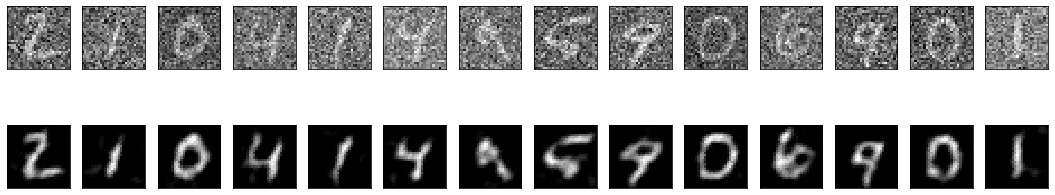

In [0]:
decoded_imgs = autoencoder.predict(input_x_test)

n = 15
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original noisy image
    ax = plt.subplot(2, n, i)
    plt.imshow(input_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display denosined image
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()